In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def load (path):
    df = pd.read_csv(path)
    return df

file_path = "/kaggle/input/loan-default-dataset/Loan_Default.csv"

df = load (file_path)

df.shape

(148670, 34)

In [2]:
def find_problematic_columns(df):
   
    problems = {}
    
    for col in df.select_dtypes(include=[np.number]).columns:
        nan_count = df[col].isna().sum()
        inf_count = np.isinf(df[col]).sum()
        
        if nan_count > 0 or inf_count > 0:
            problems[col] = {"NaN": nan_count, "Inf": inf_count}
    
    return problems

issues = find_problematic_columns(df)
print(issues)

{'rate_of_interest': {'NaN': 36439, 'Inf': 0}, 'Interest_rate_spread': {'NaN': 36639, 'Inf': 0}, 'Upfront_charges': {'NaN': 39642, 'Inf': 0}, 'term': {'NaN': 41, 'Inf': 0}, 'property_value': {'NaN': 15098, 'Inf': 0}, 'income': {'NaN': 9150, 'Inf': 0}, 'LTV': {'NaN': 15098, 'Inf': 0}, 'dtir1': {'NaN': 24121, 'Inf': 0}}


In [3]:
def fill_missing_values(df):
  
    # Categorical columns
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    for col in cat_cols:
        if df[col].isna().sum() > 0:
            mode_val = df[col].mode()[0]
            df[col] = df[col].fillna(mode_val)
    
    # Numeric columns
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in num_cols:
        missing_count = df[col].isna().sum()
        if missing_count == 0:
            continue
       
        # Fill NaN with median
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
    
    return df
    
df_filled = fill_missing_values(df)
print(df_filled.isna().sum())

ID                           0
year                         0
loan_limit                   0
Gender                       0
approv_in_adv                0
loan_type                    0
loan_purpose                 0
Credit_Worthiness            0
open_credit                  0
business_or_commercial       0
loan_amount                  0
rate_of_interest             0
Interest_rate_spread         0
Upfront_charges              0
term                         0
Neg_ammortization            0
interest_only                0
lump_sum_payment             0
property_value               0
construction_type            0
occupancy_type               0
Secured_by                   0
total_units                  0
income                       0
credit_type                  0
Credit_Score                 0
co-applicant_credit_type     0
age                          0
submission_of_application    0
LTV                          0
Region                       0
Security_Type                0
Status  

In [4]:
def drop_columns(df):
    
    cols_to_drop = ["ID"]
    df = df.drop(columns=cols_to_drop, errors="ignore")
    return df

df = drop_columns(df)
print("Columns dropped successfully!")

Columns dropped successfully!


In [5]:
# Count of each class
status_counts = df['Status'].value_counts()
print("Counts per class:\n", status_counts)

# Percentage distribution
status_percent = df['Status'].value_counts(normalize=True) * 100
print("\nPercentage distribution:\n", status_percent)

Counts per class:
 Status
0    112031
1     36639
Name: count, dtype: int64

Percentage distribution:
 Status
0    75.355485
1    24.644515
Name: proportion, dtype: float64


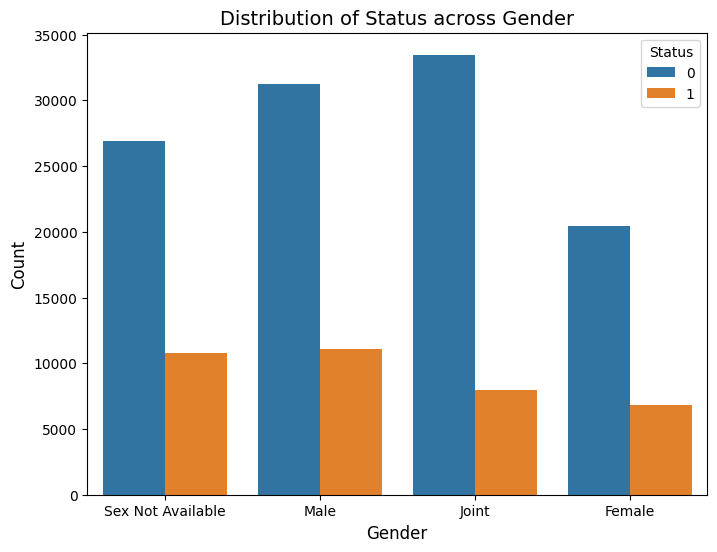

In [6]:
def plot_status_vs_gender(df, gender_col='Gender', status_col='Status'):
    
    plt.figure(figsize=(8,6))
    sns.countplot(x=gender_col, hue=status_col, data=df)
    plt.title(f'Distribution of {status_col} across {gender_col}', fontsize=14)
    plt.xlabel(gender_col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title=status_col)
    plt.show()

plot_status_vs_gender(df)

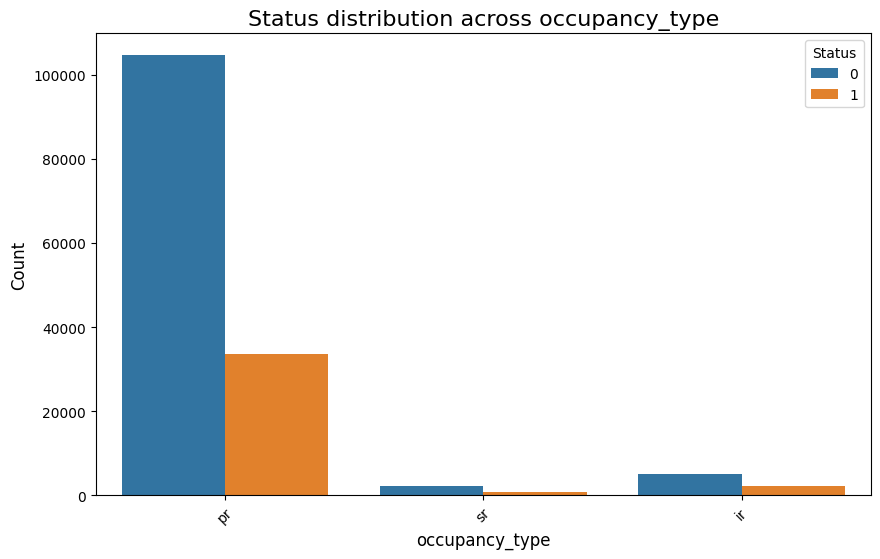

In [7]:
def plot_status_vs_category(df, category_col='occupancy_type', target_col='Status'):
    
    plt.figure(figsize=(10,6))
    sns.countplot(data=df, x=category_col, hue=target_col)
    plt.title(f"{target_col} distribution across {category_col}", fontsize=16)
    plt.xlabel(category_col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.legend(title=target_col, loc='upper right')
    plt.xticks(rotation=45)
    plt.show()

# Example usage:
plot_status_vs_category(df, category_col='occupancy_type', target_col='Status')

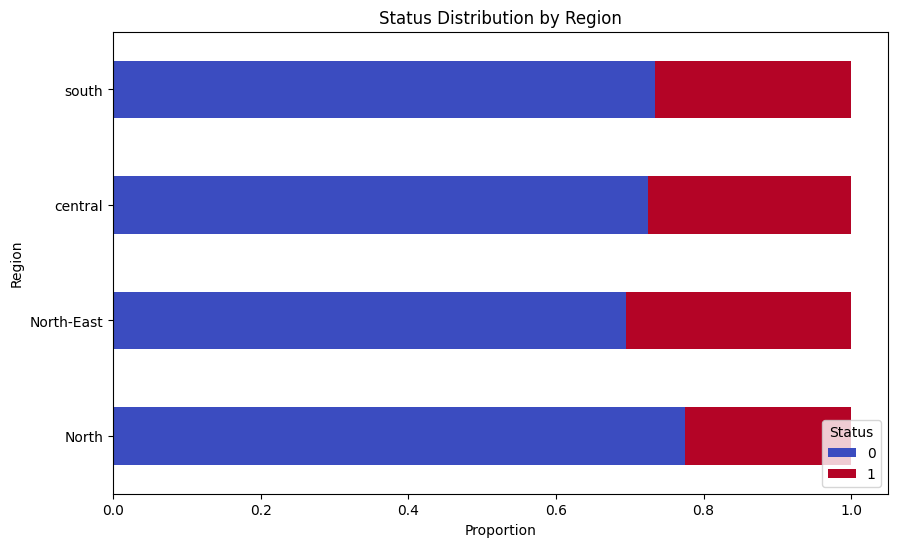

In [8]:
def plot_status_vs_region(df):
    
    status_region = df.groupby('Region')['Status'].value_counts(normalize=True).unstack()
    
    status_region.plot(kind='barh', stacked=True, figsize=(10,6), colormap='coolwarm')
    
    plt.xlabel('Proportion')
    plt.ylabel('Region')
    plt.title('Status Distribution by Region')
    plt.legend(title='Status', loc='lower right')
    plt.show()

plot_status_vs_region(df)

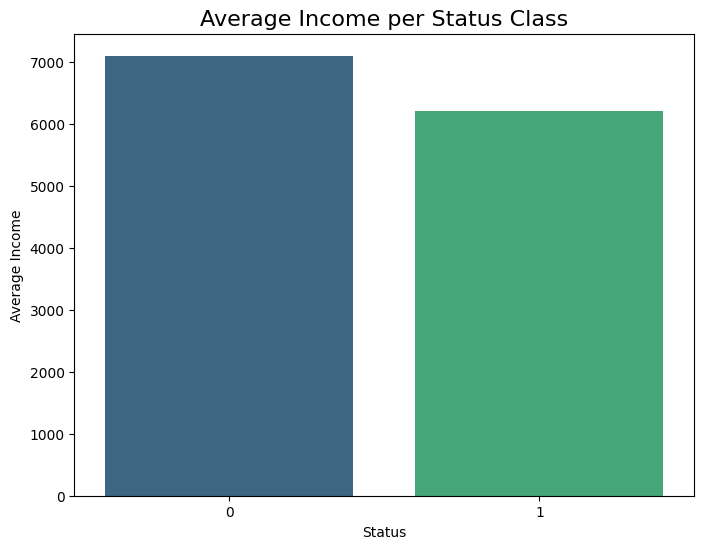

In [9]:
def plot_status_vs_income(df):
    
    plt.figure(figsize=(8,6))
    sns.barplot(x='Status', y='income', data=df, ci=None, palette='viridis')
    plt.title('Average Income per Status Class', fontsize=16)
    plt.ylabel('Average Income')
    plt.xlabel('Status')
    plt.show()

plot_status_vs_income(df)

In [10]:
def encode_dataset_full(df, label_encode_cols):
   
    encoders = {}
    
    for col in df.columns:
        if df[col].dtype == 'object':
            # Fill categorical NaNs with 'Unknown'
            df[col] = df[col].fillna('Unknown')
        else:
            # Fill numeric NaNs with median
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
    
    for col in label_encode_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))  # handle any leftover NaN
        encoders[col] = le
    
    return df, encoders

# ---------------------------
# Example usage
# ---------------------------
label_cols = ['loan_limit', 'approv_in_adv', 'Credit_Worthiness', 'open_credit', 
              'business_or_commercial', 'Neg_ammortization', 'interest_only', 
              'lump_sum_payment', 'construction_type', 'Secured_by', 
              'co-applicant_credit_type', 'submission_of_application', 'Security_Type',
              'Gender', 'loan_type', 'loan_purpose', 'occupancy_type', 
                        'total_units', 'credit_type', 'age', 'Region']


df_encoded, encoders = encode_dataset_full(df, label_cols)
print("Encoding and missing value handling done ✅")

Encoding and missing value handling done ✅


In [11]:
def target_correlation(df, target_col='Status', method='pearson', top_n=None):
    
    corr_series = df.corr(method=method)[target_col].drop(target_col)
    corr_df = corr_series.to_frame().rename(columns={target_col:'correlation'})
    corr_df['abs_corr'] = corr_df['correlation'].abs()
    corr_df = corr_df.sort_values(by='abs_corr', ascending=False)
    
    if top_n:
        corr_df = corr_df.head(top_n)
    
    return corr_df

corr_with_status = target_correlation(df, target_col='Status', top_n=20)
print(corr_with_status)

                           correlation  abs_corr
lump_sum_payment             -0.187752  0.187752
Neg_ammortization            -0.155835  0.155835
co-applicant_credit_type      0.144239  0.144239
submission_of_application     0.122410  0.122410
credit_type                   0.112760  0.112760
Upfront_charges              -0.095094  0.095094
business_or_commercial       -0.092550  0.092550
dtir1                         0.082432  0.082432
property_value               -0.080905  0.080905
income                       -0.060618  0.060618
loan_limit                    0.053332  0.053332
loan_type                     0.052301  0.052301
Gender                        0.051794  0.051794
Interest_rate_spread         -0.049536  0.049536
age                           0.048807  0.048807
Region                        0.047142  0.047142
rate_of_interest             -0.046738  0.046738
LTV                           0.042656  0.042656
approv_in_adv                -0.037371  0.037371
loan_amount         

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


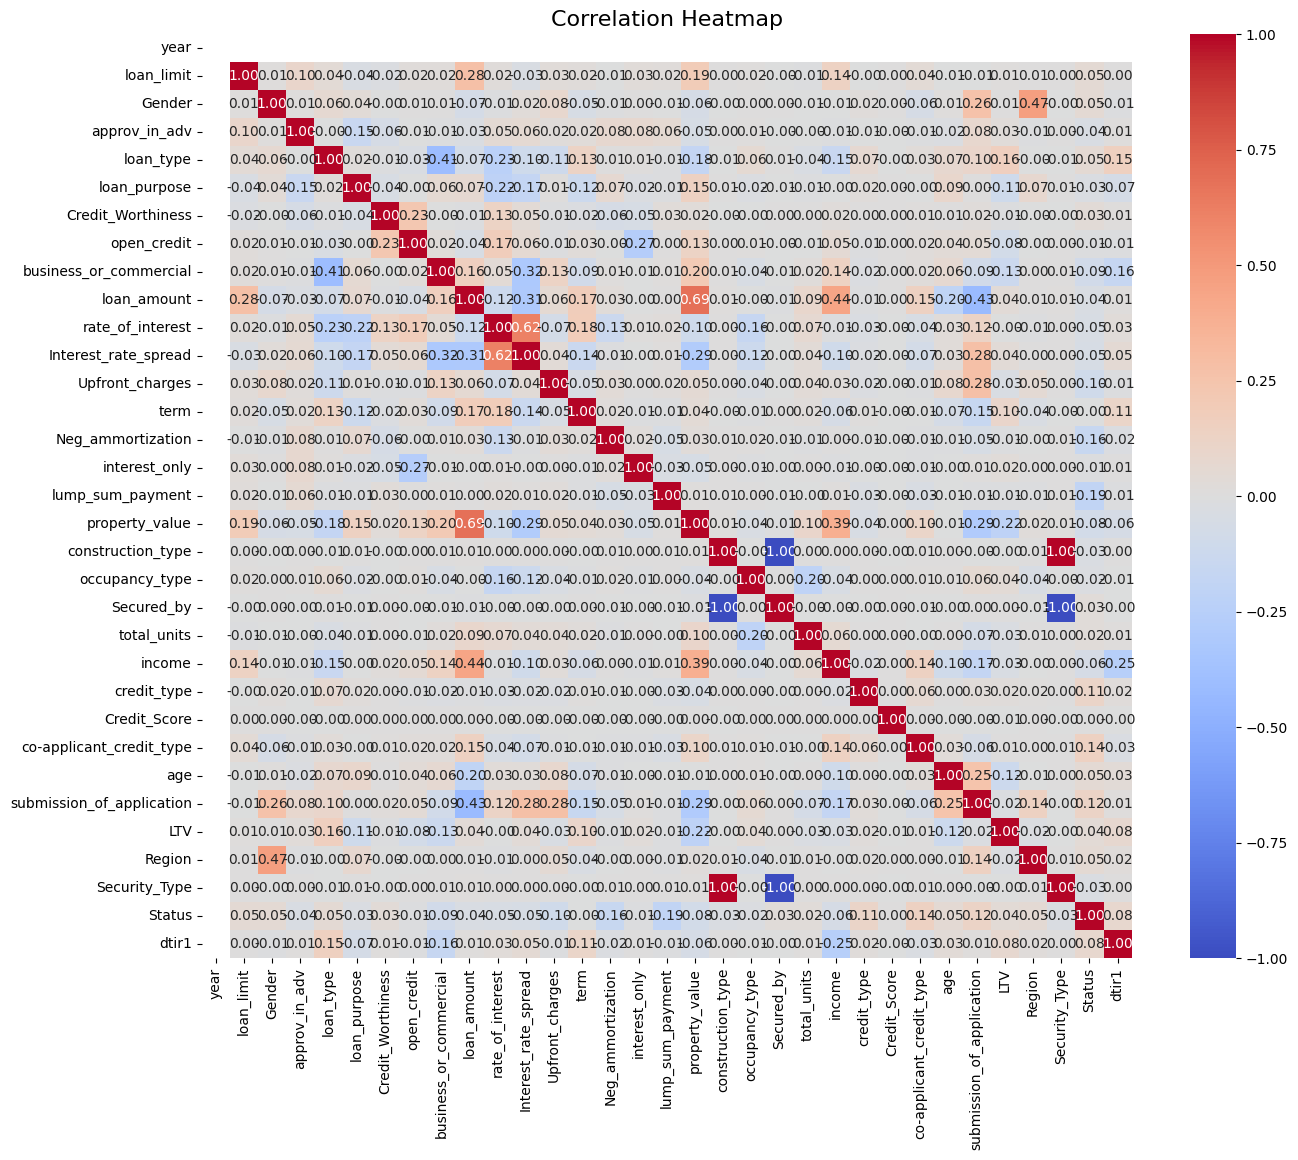

In [12]:
def plot_corr_heatmap(df, figsize=(15, 12), annot=True, cmap='coolwarm'):
    
    plt.figure(figsize=figsize)
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=annot, fmt=".2f", cmap=cmap, cbar=True)
    plt.title("Correlation Heatmap", fontsize=16)
    plt.show()

# Example usage:
plot_corr_heatmap(df)


# Feature Engineering

In [13]:
def scale_numerical(df, numerical_cols):
   
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df, scaler

# Example usage
numeric_cols_to_scale = ['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 
                         'Upfront_charges', 'term', 'property_value', 'income', 
                         'Credit_Score', 'LTV', 'dtir1']

df_scaled, scaler = scale_numerical(df, numeric_cols_to_scale)

print("Numeric columns scaled ✅")

Numeric columns scaled ✅


In [14]:
def stratified_train_test_split(df, target_col='Status', test_size=0.2, random_state=42):
   
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        stratify=y, 
        random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

# Example usage:
X_train, X_test, y_train, y_test = stratified_train_test_split(df, target_col='Status', test_size=0.2)

print("Stratified train-test split done ✅")
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

Stratified train-test split done ✅
Train size: 118936 Test size: 29734


# ML Modeling 

In [15]:
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # probability for class 1

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("F1 Score:", f1)
print("ROC-AUC Score:", roc_auc)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)

F1 Score: 0.5288501888375996
ROC-AUC Score: 0.7619429870917296

Confusion Matrix:
 [[15711  6695]
 [ 2287  5041]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.70      0.78     22406
           1       0.43      0.69      0.53      7328

    accuracy                           0.70     29734
   macro avg       0.65      0.69      0.65     29734
weighted avg       0.76      0.70      0.72     29734



In [16]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")


model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print(f"\nF1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Scale Pos Weight: 3.06
Confusion Matrix:
 [[22402     4]
 [    2  7326]]

F1-Score: 0.9996
ROC-AUC: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



In [17]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, roc_auc_score

def cross_val_metrics(model, X, y, cv=5, random_state=42):

    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    
    # F1 score
    f1 = cross_val_score(model, X, y, cv=skf, scoring=make_scorer(f1_score))
    
    # ROC-AUC
    roc_auc = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
    
    results = {
        'F1_mean': np.mean(f1),
        'F1_std': np.std(f1),
        'ROC_AUC_mean': np.mean(roc_auc),
        'ROC_AUC_std': np.std(roc_auc)
    }
    
    return results


# Logistic Regression with class_weight='balanced'
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# XGBoost with scale_pos_weight
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

# Cross-validation scores
logreg_cv = cross_val_metrics(logreg, X_train, y_train, cv=5)
xgb_cv = cross_val_metrics(xgb_model, X_train, y_train, cv=5)

print("Logistic Regression CV scores:", logreg_cv)
print("XGBoost CV scores:", xgb_cv)

Logistic Regression CV scores: {'F1_mean': 0.5251262129998695, 'F1_std': 0.005057770225913534, 'ROC_AUC_mean': 0.7593296424097938, 'ROC_AUC_std': 0.0028495376531859715}
XGBoost CV scores: {'F1_mean': 0.9998123987367149, 'F1_std': 9.943243325255283e-05, 'ROC_AUC_mean': 0.9999857161624031, 'ROC_AUC_std': 1.4756635728921209e-05}


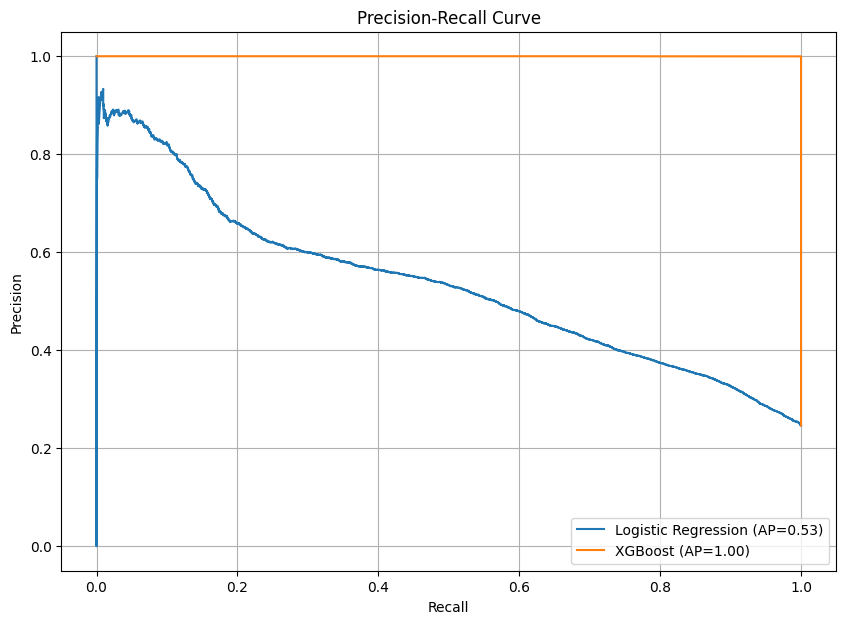

In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curves(models, X_test, y_test):
    
    plt.figure(figsize=(10, 7))
    
    for name, model in models.items():
        y_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        avg_precision = average_precision_score(y_test, y_proba)
        
        plt.plot(recall, precision, label=f"{name} (AP={avg_precision:.2f})")
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


# Logistic Regression
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# XGBoost
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Plot PR curves
models = {'Logistic Regression': logreg, 'XGBoost': xgb_model}
plot_precision_recall_curves(models, X_test, y_test)